We'll make two studies:
1. Create an ML model to forecast/predict the level of unemployment in the US.
2. Create a linear model to predict the same, but for another purpose: to check if the varible "stock price of SP500" is statistically significant for the model (i.e., if it's coefficient should be zero or different from zero). For that, we'll do a hypothesis test.


In [1]:
# economic information from yahoo finance, already installed it
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import datetime

We'll import our unemployment data from the package pandas_datareader, which has axes to a collection of datasets from the Federal Reserve of the US.
For reference, we'll consider the following framework of time: from the 1st of January of 2000 till the 21st December 2025.

In [15]:
# set time period of our study
start_date = '2000-01-01'
end_date = '2025-12-21'

unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
unemployment.head(32)

,UNRATE
DATE,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0
2000-06-01,4.0
2000-07-01,4.0
2000-08-01,4.1
2000-09-01,3.9


I want to study the depndence of unemployment with respect of financial and social data: price of sp500 bonds, number of unemployment benefit applications, industrial production, etc.
For the sp500 bonds data we'll extract the information from the Yahoo Finance package.
For the other data that I am interested in, I will import it from the datasets in the federal reserve (that can be found using the pandas_datareader package).

In [16]:
# download sp500 from yahoo finance
# data till today
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-21', auto_adjust  = True)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


The columns close, high, low and open have very similar values, since they describe the evolution regarding the price of the sp500 companies' price of the bonds. Maybe it's not a good idea to include all of these in the model, since they might be very correlated. Let's check that:

Text(0.5, 1.0, 'Correlation Matrix of S&P 500 Features')

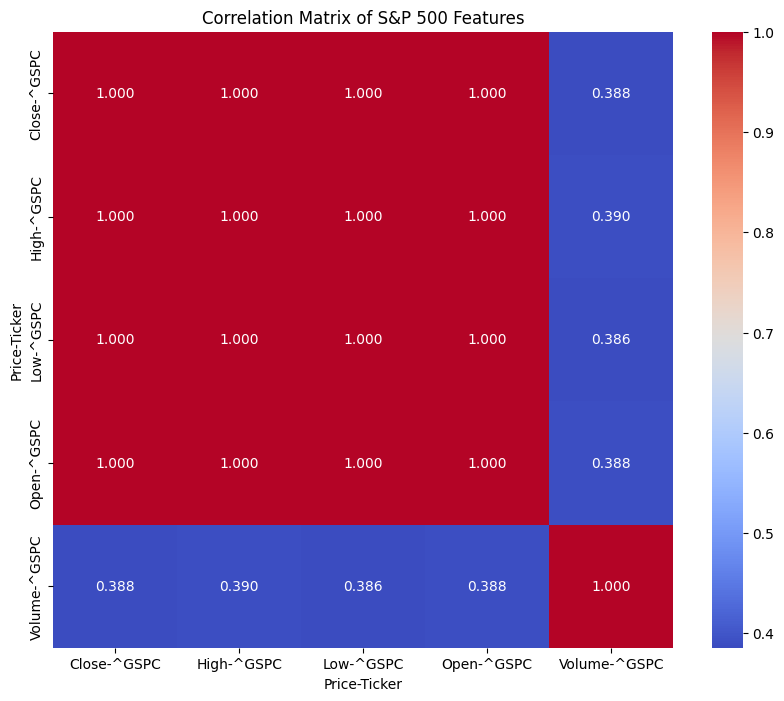

In [17]:
# correlation matrix of sp500 printed in a fancy way
corr_matrix = sp500.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix of S&P 500 Features')

In fact they are! So it won't be a good idea to "throw" all these variables to the model and, as if it were a black-box, think that it will find the intrinsicate and often complicated dependencies.
We'll keep it simple with this set of varibles, and will only use the closing price of the bonds.

In [18]:
sp500_reduced = sp500["Close"]

# convert into dataframe to treat more easily
sp500_reduced = pd.DataFrame(sp500_reduced)
sp500_reduced.head()

Ticker,^GSPC
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


Now we'll be downloading other social and economical data that I think are interesting for our model to train on. We'll use the same start and end dates as before.

In [19]:
# I will create a dictionary with the FRED indicators I want to download and an alias for each one
fred_indicators = {
    'ICSA': 'Initial_Claims',          
    'FEDFUNDS': 'Interest_Rate',        
    'INDPRO': 'Industrial_Production',  
    'UMCSENT': 'Consumer_Sentiment',    
    'CPIAUCSL': 'CPI_Inflation',        
}

print("Descargando datos de FRED...")
df = web.DataReader(list(fred_indicators.keys()), 'fred', start_date, end_date)

# Rename columns to have a human understandable names :)
df = df.rename(columns=fred_indicators)
df.head(32) # plot more than a month 

Descargando datos de FRED...


,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation
DATE,,,,,
2000-01-01,286000.0,5.45,91.5380,112.0,169.3
2000-01-08,298000.0,NaN,NaN,NaN,NaN
2000-01-15,289000.0,NaN,NaN,NaN,NaN
2000-01-22,284000.0,NaN,NaN,NaN,NaN
2000-01-29,285000.0,NaN,NaN,NaN,NaN
2000-02-01,NaN,5.73,91.8239,111.3,170.0
2000-02-05,312000.0,NaN,NaN,NaN,NaN
2000-02-12,300000.0,NaN,NaN,NaN,NaN
2000-02-19,283000.0,NaN,NaN,NaN,NaN


What's happening!? Is our data wrong? No it is not, but these variables have different periodicities. So we'll have to set one common periodicity across all our variables (and also the target ones) so that our model can be trained properly. I will use months.

In [20]:
# join df and sp500_reduced on the date index
df = df.join(sp500_reduced, how='outer')
# rename the column from Close to SP500_Index
df = df.rename(columns={'^GSPC': 'SP500_Index'})
df.head(60)

,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation,SP500_Index
2000-01-01,286000.0,5.45,91.5380,112.0,169.3,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,1455.219971
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.420044
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.109985
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.449951
2000-01-07,NaN,NaN,NaN,NaN,NaN,1441.469971
2000-01-08,298000.0,NaN,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN,NaN,1457.599976
2000-01-11,NaN,NaN,NaN,NaN,NaN,1438.560059
2000-01-12,NaN,NaN,NaN,NaN,NaN,1432.250000


In [21]:
# we'll also join the unemployment data
df = df.join(unemployment, how='outer')
df.head()

,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation,SP500_Index,UNRATE
2000-01-01,286000.0,5.45,91.538,112.0,169.3,NaN,4.0
2000-01-03,NaN,NaN,NaN,NaN,NaN,1455.219971,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.420044,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.109985,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.449951,NaN


Great! Now that we have grouped our data, we will put it in a nice "monthly" format. For that, there are some columns where we have to decide what to with the daily data. I will apply the following transformations:
1. Average the sp500 bond price for the month (taking into account that this is a daily variable).
2. Average the number of claims per month (taking into accoutn that this is a weekly variable).
3. Average the unemployment rate per month (taking into account that this is a daily varible).
4. The rest of the variables are already in a monthly format.


In [26]:
""" Now that we have grouped our data, we will put it in a nice "monthly" format. For that, there are some columns where we have to decide what to with the daily data. I will apply the following transformations:
1. Average the sp500 bond price for the month (taking into account that this is a daily variable).
2. Average the number of claims per month (taking into accoutn that this is a weekly variable).
3. Average the unemployment rate per month (taking into account that this is a daily varible).
4. The rest of the variables are already in a monthly format. """
df_monthly = pd.DataFrame()
df_monthly['SP500_Index'] = df['SP500_Index'].resample('ME').mean()
df_monthly['Initial_Claims'] = df['Initial_Claims'].resample('ME').mean()
df_monthly['Unemployment_Rate'] = df['UNRATE'].resample('ME').mean()
df_monthly['Interest_Rate'] = df['Interest_Rate'].resample('ME').last()
df_monthly['Industrial_Production'] = df['Industrial_Production'].resample('ME').last()
df_monthly['Consumer_Sentiment'] = df['Consumer_Sentiment'].resample('ME').last()
df_monthly['CPI_Inflation'] = df['CPI_Inflation'].resample('ME').last()
df_monthly.head()

,SP500_Index,Initial_Claims,Unemployment_Rate,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation
2000-01-31,1425.585504,288400.0,4.0,5.45,91.5380,112.0,169.3
2000-02-29,1388.874500,293750.0,4.1,5.73,91.8239,111.3,170.0
2000-03-31,1442.212599,274750.0,4.0,5.85,92.1504,107.1,171.0
2000-04-30,1461.355257,271600.0,3.8,6.02,92.6989,109.2,170.9
2000-05-31,1418.479548,282250.0,4.0,6.27,92.9499,110.7,171.2


In [27]:
df_monthly.shape

(312, 7)

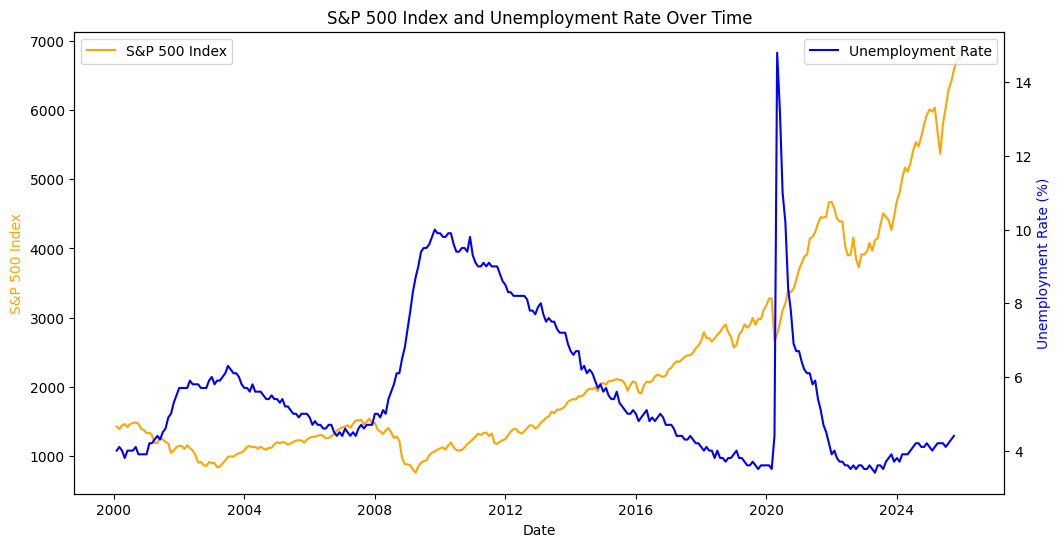

In [34]:
# plot the evolution of unemployment rate and sp500 index with different y axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_monthly.index, df_monthly['SP500_Index'], label='S&P 500 Index', color='orange')
ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Index', color='orange')
ax2.set_ylabel('Unemployment Rate (%)', color='b')
plt.title('S&P 500 Index and Unemployment Rate Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

--- RESULTADOS ---
MAE: 0.7590
MAPE: 17.76%


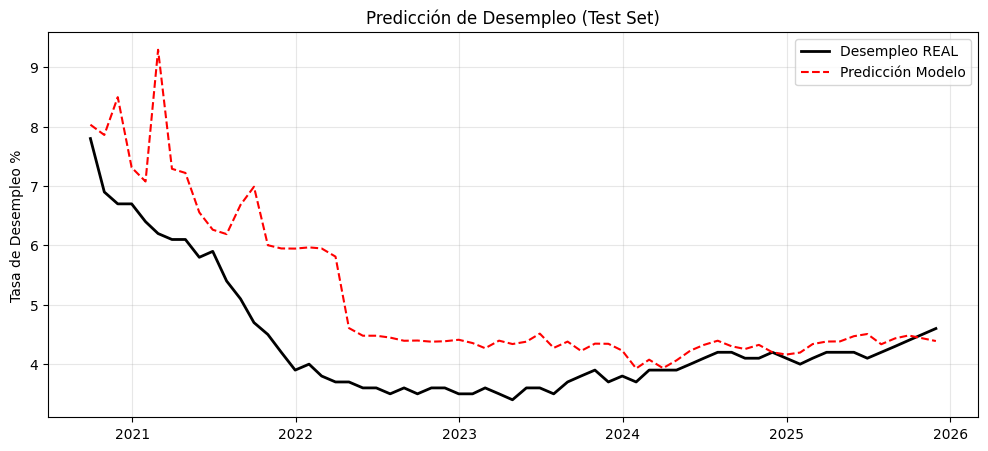

C:\Users\Leonel\AppData\Local\Temp\ipykernel_16464\4127735826.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


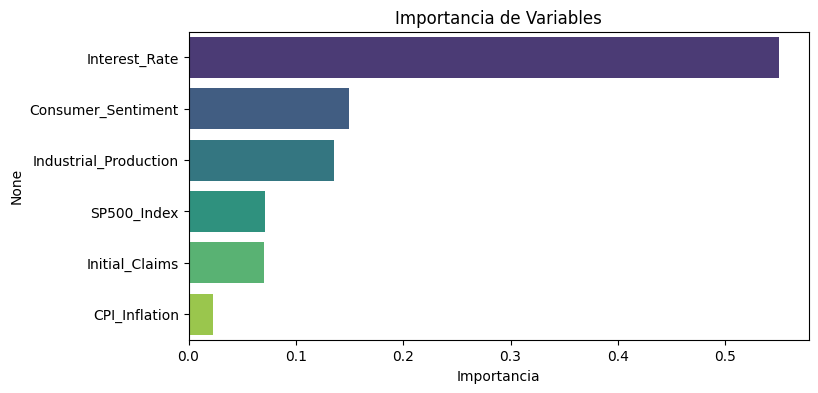

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1) Preparar features y target
features = [
    'SP500_Index',
    'Initial_Claims',
    'Interest_Rate',
    'Industrial_Production',
    'Consumer_Sentiment',
    'CPI_Inflation'
]

# Crear target (desempleo del mes siguiente) - usar shift(-1) en lugar de shift(-2)
df_monthly['Target_Next_Month_Unemployment'] = df_monthly['Unemployment_Rate'].shift(0)

# Seleccionar X,y y limpiar
data = df_monthly[features + ['Target_Next_Month_Unemployment']].dropna()
X = data[features].astype(float)
y = data['Target_Next_Month_Unemployment'].astype(float)

# 2) Split temporal usando train_test_split (80% train, 20% test) sin shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3) Entrenar RandomForest
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 4) Predecir y evaluar
predictions = model.predict(X_test)
mae = (y_test - predictions).abs().mean()
mape = ((y_test - predictions).abs() / y_test).mean() * 100

print("--- RESULTADOS ---")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# 5) Gráficos
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Desempleo REAL', color='black', linewidth=2)
plt.plot(y_test.index, predictions, label='Predicción Modelo', color='red', linestyle='--')
plt.title('Predicción de Desempleo (Test Set)')
plt.ylabel('Tasa de Desempleo %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6) Importancia de variables
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Importancia de Variables')
plt.xlabel('Importancia')
plt.show()


In [58]:
X_train.head()

,SP500_Index,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation
2000-01-31,1425.585504,288400.0,5.45,91.5380,112.0,169.3
2000-02-29,1388.874500,293750.0,5.73,91.8239,111.3,170.0
2000-03-31,1442.212599,274750.0,5.85,92.1504,107.1,171.0
2000-04-30,1461.355257,271600.0,6.02,92.6989,109.2,170.9
2000-05-31,1418.479548,282250.0,6.27,92.9499,110.7,171.2
